In [1]:
from data_processing_helper import * 
import warnings
warnings.filterwarnings('ignore')

from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure



## Specific helper functions

In [2]:
def getOutputLabelsAndEpochTimes(event_df):
    # Generates the ordered list of output labels and epoch time pairs
    # Input: event_df -- the event dataframe from the csv file
    # Output: 
    #    output_labels -- [1, 2, 4, 3, etc] where the integers correspond to the trial type encoded
    #    epoch_times -- [[<timestamp of start>, <timestamp of end>], [<timestamp of start>, <timestamp of end>], etc]
    
    output_labels = []
    epoch_times = []
    current_epoch = []
    for index, row in event_df.iterrows():
        event_info = row['EventStart'].split("_")
        if event_info[0] == 'start': 
            output_labels.append(int(event_info[1]))
            current_epoch.append(row['time'])
        else :
            current_epoch.append(row['time'])
            epoch_times.append(list(current_epoch))
            current_epoch = []
    return np.array(output_labels), np.array(epoch_times)

In [3]:
def getEEGEpochs(epoch_times, eeg_df, target_num_trials=1000):
    # Slices and generates the epochs in the eeg_df given the epoch_times
    # Input: 
    #    epoch_times: [[<timestamp of start>, <timestamp of end>], [<timestamp of start>, <timestamp of end>], etc]
    #    eeg_df: dataframe from csv file
    # Output: 
    #    a numpy array containing eeg_epochs (#epoch, #chans, #timepoints)
    eeg_epochs = []
    for epoch_time in epoch_times: 
        baseline_df = eeg_df[(eeg_df['time'] > (epoch_time[0] - 1.5)) & (eeg_df['time'] < ((epoch_time[0])))]
        baseline_df = baseline_df.drop(columns=['time'])
        baselines = np.mean(baseline_df[eeg_chans].values, 0)
        sub_df = eeg_df[(eeg_df['time'] > epoch_time[0]) & (eeg_df['time'] < epoch_time[1])]
        sub_df = sub_df.drop(columns=['time'])
        sub_df = sub_df - baselines
        num_above = len(sub_df) - target_num_trials
        if num_above >= 0:
            epoch = np.array(sub_df.values[num_above // 2: len(sub_df) - num_above // 2])[:1000]
            eeg_epochs.append(epoch.T)
            if len(epoch) != 1000:
                print("Warning: Potential off by 1 error. Found trail with != 1000 samples:", len(epoch))
        else: 
            print("Warning: Epoch with less than", target_num_trials, "eeg samples")
    return np.array(eeg_epochs)


In [4]:
# Spectrogram plotting
def plotSpectrogram_fromEEG(eeg_data, fs=eeg_fs, pre_cut_off_freq=0, post_cut_off_freq=120):
    f, t, Sxx = signal.spectrogram(eeg_data, fs=fs)
    # Calculate the frequency point that corresponds with the desired cut off frequencies
    pre_cut = int(len(f)*(pre_cut_off_freq / f[-1]))
    post_cut = int(len(f)*(post_cut_off_freq / f[-1]))
    plt.pcolormesh(t, f[pre_cut:post_cut], Sxx[pre_cut:post_cut], shading='gouraud')
    plt.colorbar()
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (sec)")

In [5]:
def indexClosest(target_time, eeg_df) :
    start_time = eeg_df['time'][0]
    elems = eeg_df[np.isclose(target_time-start_time, (eeg_df['time']-start_time).values, atol=1e-04)]
    if (len(elems) <= 0): 
        print("Warning: none 1e-04 close")
        elems = eeg_df[np.isclose(target_time-start_time, (eeg_df['time']-start_time).values, atol=1e-03)]
    if (len(elems) <= 0): 
        print("Warning: none 1e-03 close")
        elems = eeg_df[np.isclose(target_time-start_time, (eeg_df['time']-start_time).values, atol=1e-02)]
    if (len(elems) <= 0): 
        print("Warning: none 1e-02 close")
        return -1
    else: 
        print("len elems", len(elems))
        return elems.iloc[0].name



### Main

In [6]:
## Loading data without EMG
eeg_filename = "./data/self_recorded/eeg_data 15_motorvis.csv"
event_filename = "./data/self_recorded/event_data 15_motorvis.csv"

eeg_chans = ['C4','C2', 'C1', 'C3']
chans = eeg_chans
eeg_df = pd.read_csv(eeg_filename)
eeg_df.columns=['time','C4', 'C2', 'C1', 'C3']

event_df = pd.read_csv(event_filename)
event_df.columns=['time', 'EventStart']
event_types = {0:"eye_close", 1:"left", 2:"right", 3:"foot", 4:"idle"}

# Filter the full data
filtered_df = eeg_df.copy()
for chan in chans:
    filtered_df[chan] = filterEEG(filtered_df[chan].values)

In [7]:
# ## Loading data with EMG
# eeg_filename = "./data/self_recorded/eeg_data 15_withEMG.csv"
# event_filename = "./data/self_recorded/event_data 15_withEMG.csv"

# eeg_chans = ['C4','C2', 'C1', 'C3']
# chans = ['EMG_R', 'EMG_L', 'VEOG'] + eeg_chans
# eeg_df = pd.read_csv(eeg_filename)
# eeg_df.columns=['time'] + chans

# event_df = pd.read_csv(event_filename)
# event_df.columns=['time', 'EventStart']
# event_types = {0:"eye_close", 1:"left", 2:"right", 3:"foot", 4:"idle"}

# # Filter the full data
# filtered_df = eeg_df.copy()
# for chan in chans:
#     filtered_df[chan] = filterEEG(filtered_df[chan].values)

In [8]:
filtered_df.head(2)

,time,C4,C2,C1,C3
0,1.602196e+09,-451.295598,-689.560321,-266.691192,-1062.534000
1,1.602196e+09,21110.796004,19952.002466,25496.237674,25480.294684


In [9]:
event_df.head(2)

,time,EventStart
0,1.602196e+09,start_0
1,1.602196e+09,end_0


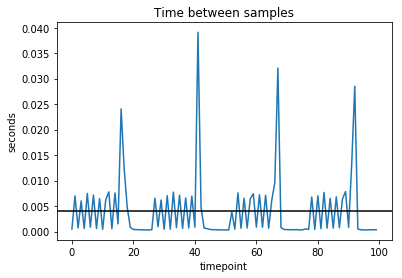

In [10]:
# The sampling rate is not conistent between trials
plt.plot(np.diff(eeg_df['time'])[:100])
plt.axhline(y=1/250, c='black')
plt.title("Time between samples")
plt.ylabel("seconds")
plt.xlabel("timepoint")
plt.show()

In [11]:
# However, the average sampling rate time difference is close enough to 1/250 within 100 samples. 
np.mean(np.diff(eeg_df['time'])[:100])

0.0040485882759094234

In [12]:
# Process dfs to get labels, raw eeg epochs, epochs of filtered eeg data, filtered epoch data
output_labels, epoch_times = getOutputLabelsAndEpochTimes(event_df)
raw_eeg_epochs = getEEGEpochs(epoch_times, eeg_df) # Raw eeg epochs
filtered_epochs = getEEGEpochs(epoch_times, filtered_df) # Epoched after filtering
epoch_then_filter_epochs = getFilteredEpochs(raw_eeg_epochs) # Filtered after epoching


# Create DataFrames
raw_eeg_epoch_df = getDF(raw_eeg_epochs, output_labels, epoch_times, chans)
filtered_epoch_df = getDF(filtered_epochs, output_labels, epoch_times, chans)
filtered_epoch_df.head(20)

epoch_then_filter_df = getDF(epoch_then_filter_epochs, output_labels, epoch_times, chans)


## View PSDs

In [13]:
filtered_epoch_df

,start_time,event_type,C4,C2,C1,C3
0,1.602196e+09,0,"[-32.98735752231004, -19.89989251275306, -5.93...","[-37.02615064019607, -26.940274093366718, -15....","[-31.67332691599604, -24.661218586724246, -17....","[-47.94237093200946, -34.827445934385175, -19...."
1,1.602196e+09,0,"[-4.451156853010154, -7.123224619790985, 0.592...","[-12.188254615814582, -13.377834601560071, -2....","[-4.457634532474931, -5.052619306078695, 2.567...","[-11.796242050579552, -14.395028193589908, -2...."
2,1.602196e+09,0,"[-5.488471627082561, -6.746418466274065, -0.80...","[2.8358730047803897, 0.818143617148121, 6.3655...","[-6.459763632798419, -8.670855700380539, -5.17...","[0.5514873540888546, 0.4565664379710982, 8.273..."
3,1.602196e+09,3,"[-1.9499328547906956, -4.692655128130223, -5.4...","[0.2873274214692938, -2.2876390926341528, -3.3...","[-1.2778387648684593, -3.423748423024509, -4.8...","[-6.534295266712101, -8.217770600234498, -6.59..."
4,1.602196e+09,2,"[-7.583728434462952, -12.525818235982436, -14....","[-12.928541102175002, -16.870241791541396, -18...","[-4.951055289853233, -5.072738828980404, -3.60...","[-16.616656565680675, -30.40767797836689, -39...."
...,...,...,...,...,...,...
58,1.602196e+09,3,"[6.931209112403182, 8.734627121173098, 6.48223...","[4.28144836670419, 5.266520181544583, 2.780381...","[5.57652220625315, 6.120178427671201, 2.794673...","[11.83675032148747, 12.611715138956614, 9.9952..."
59,1.602196e+09,4,"[-1.6902095138474553, -0.6580170509836402, -4....","[0.7831442852502289, 3.605615480422082, -0.191...","[-8.731696415582777, -7.415206944838227, -10.6...","[-1.89250740066574, 1.7146603177429027, -1.831..."
60,1.602196e+09,1,"[2.923382298465124, 5.159610387279769, 18.6913...","[-0.020303829727048972, 3.224045092878243, 18....","[-3.52162828077453, 0.8427457464099819, 12.900...","[-19.61769623701586, -19.654150565802077, -4.1..."
61,1.602196e+09,1,"[-1.0598681960727516, 3.613514558026306, 2.850...","[1.0616900947381374, 5.1376590077153965, 4.353...","[3.1786349807346945, 4.833240611752888, 1.9061...","[12.904191424848074, 21.590234953120014, 21.96..."


In [14]:
# Get PSD averages for each channel for each event type 
# (0 = eye close, 1 = left, 2 = right, 3 = foot, 4 = idle)
psd_averages_by_type = {}

for event_type in event_types.keys(): 
    if len(filtered_epoch_df[filtered_epoch_df["event_type"] == event_type]) > 0:  
        psds_only_one_type={}
        freqs_only_one_type={}
        for i, row in filtered_epoch_df[filtered_epoch_df["event_type"] == event_type].iterrows(): 
            for ch in chans: 
                if ch not in psds_only_one_type: 
                    psds_only_one_type[ch] = list()
                    freqs_only_one_type[ch] = list()
                f, p = getMeanFreqPSD(row[ch])
                psds_only_one_type[ch].append(p)
                freqs_only_one_type[ch].append(f)
        avg_psds_one_type = {}
        for ch in chans:
            psds_only_one_type[ch] = np.array(psds_only_one_type[ch])
            avg_psds_one_type[ch] = np.mean(psds_only_one_type[ch], axis=0)
        psd_averages_by_type[event_type] = dict(avg_psds_one_type)

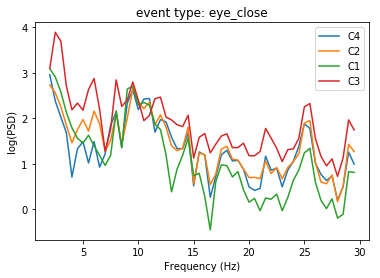

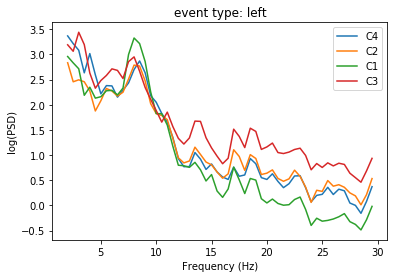

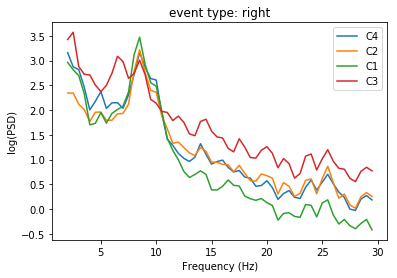

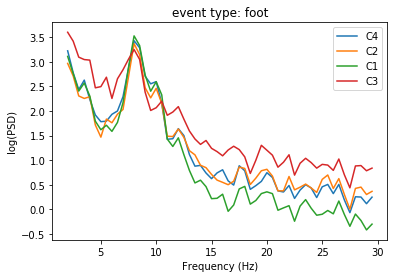

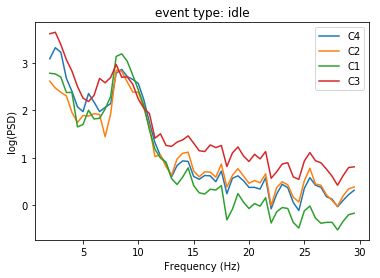

In [15]:
# View Average PSDs
for event_type in event_types.keys(): 
    if len(filtered_epoch_df[filtered_epoch_df["event_type"] == event_type]) > 0: 
        for ch in eeg_chans[:]: 
            plotPSD(freqs_only_one_type[eeg_chans[0]][0], psd_averages_by_type[event_type][ch],pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)

        plt.legend()
        plt.title("event type: " + event_types[event_type])
        plt.show()

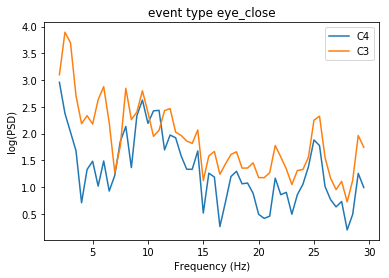

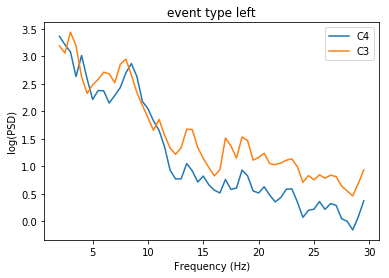

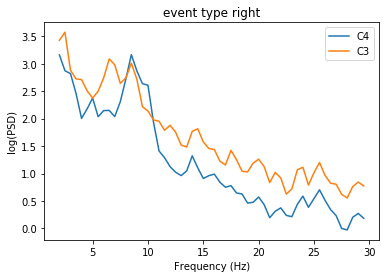

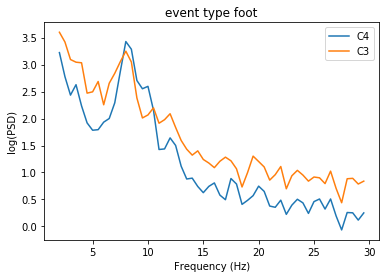

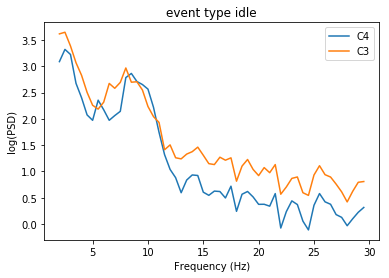

In [16]:
# View Average PSDs (2 channels)
for event_type in event_types.keys(): 
    if len(filtered_epoch_df[filtered_epoch_df["event_type"] == event_type]) > 0:  
        for ch in ['C4', 'C3']: 
            plotPSD(freqs_only_one_type[chans[0]][0], psd_averages_by_type[event_type][ch],pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)

        # Plot for each event type
        plt.legend()
        plt.title("event type " + event_types[event_type])
        plt.show()

len elems 1


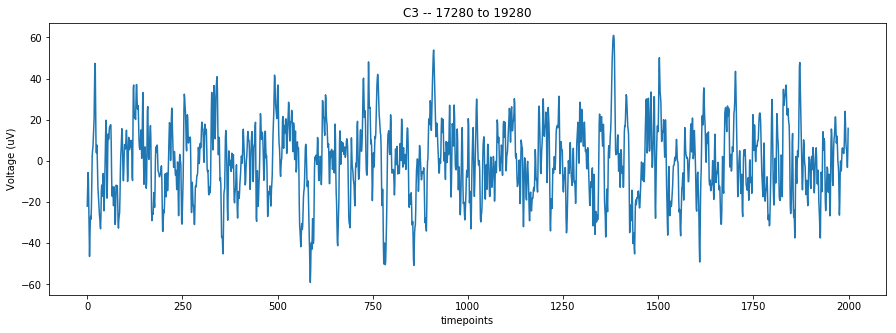

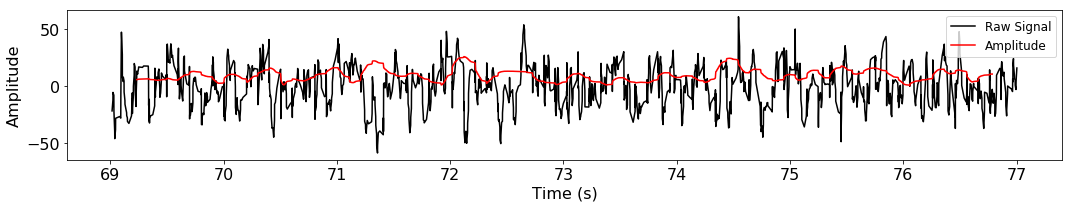

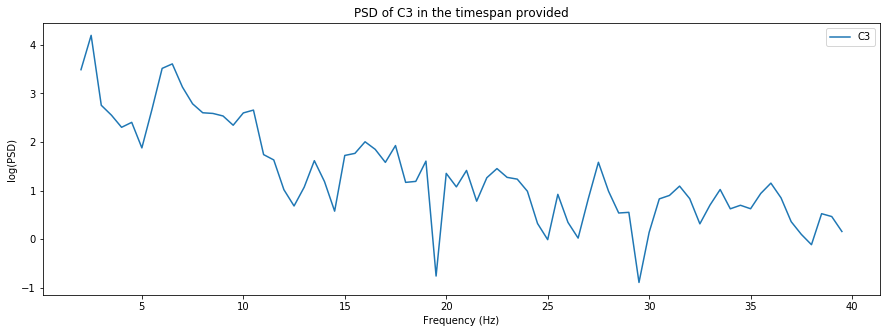

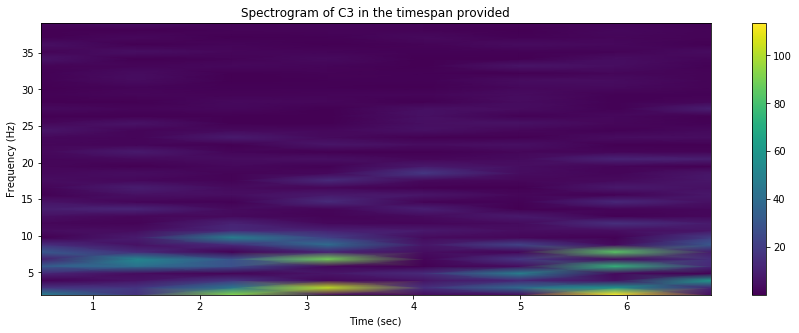

In [17]:
# Try adjust these variables to see different time ranges! 
# A single trial is 4 seconds or 1000 timpoints (4 ms per timepoint)
# Hint: refer to the Epoched data dataframe for the time of each trial
start_time_timepoints = indexClosest(filtered_epoch_df['start_time'][8], eeg_df)
end_time_timepoints = start_time_timepoints + 2000 # Specify number of more timepoints we want past start

# Plot a single EEG channel
plt.figure(figsize=(15,5))
plt.plot(filtered_df['C3'].values[start_time_timepoints:end_time_timepoints])
plt.title("C3 -- " + str(start_time_timepoints) + " to " + str(end_time_timepoints))
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()

# Plot instananeous alpha amplitude
sig = filtered_df['C3'].values[start_time_timepoints:end_time_timepoints]
times = filtered_df['time'].values[start_time_timepoints:end_time_timepoints] - filtered_df['time'][0]
amp = amp_by_time(sig, eeg_fs, (7, 12))
plot_instantaneous_measure(times, [sig, amp], 'amplitude',
                           labels=['Raw Signal', 'Amplitude'])

# # Plot a single EOG channel
# plt.figure(figsize=(15,5))
# plt.plot(eeg_df['EOG:ch01'].values[start_time_timepoints:end_time_timepoints])
# plt.title("EOG:ch01 -- " + str(start_time_timepoints) + " to " + str(end_time_timepoints))
# plt.xlabel("timepoints")
# plt.ylabel("Voltage (uV)")
# plt.show()

# Plot the PSD of the single EEG channel
plt.figure(figsize=(15,5))
plotPSD_fromEEG(filtered_df['C3'].values[start_time_timepoints:end_time_timepoints], pre_cut_off_freq=2, post_cut_off_freq=40,label="C3")
plt.title("PSD of C3 in the timespan provided")
plt.legend()
plt.show()

# Plot the spectrogram of the single EEG channel
plt.figure(figsize=(15,5))
plotSpectrogram_fromEEG(filtered_df['C3'].values[start_time_timepoints:end_time_timepoints], pre_cut_off_freq=2, post_cut_off_freq=40)
plt.title("Spectrogram of C3 in the timespan provided")
plt.show()



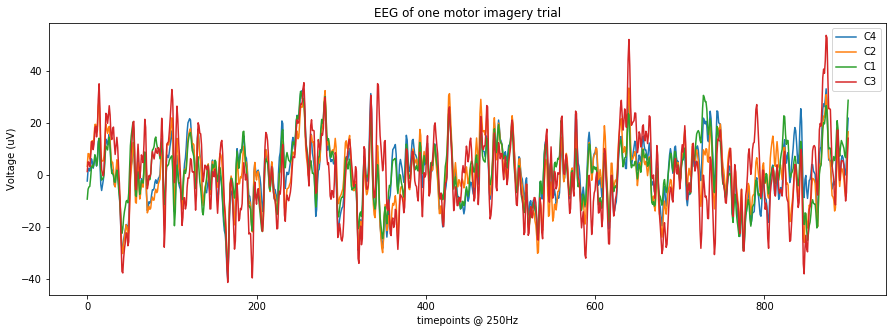

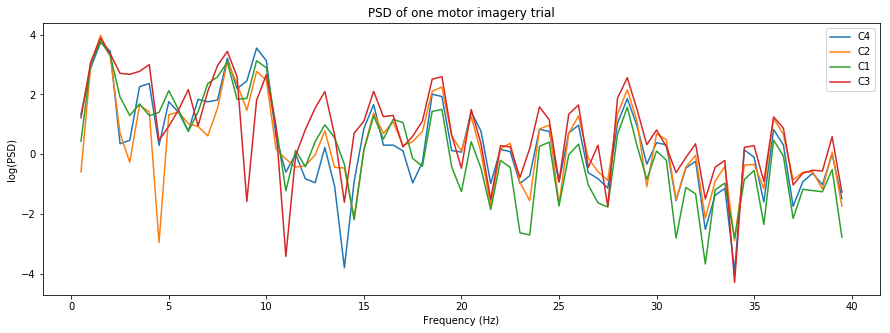

In [18]:
# Visualize EEG and PSD for one trial
plt.figure(figsize=(15,5))
trial_num = 17

for ch in eeg_chans: 
    plt.plot(filtered_epoch_df[ch][trial_num][100:1000], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EEG of one motor imagery trial")
plt.legend() 
plt.show()

plt.figure(figsize=(15,5))
for ch in eeg_chans: 
    plotPSD_fromEEG(filtered_epoch_df.iloc[trial_num][ch][100:1000], pre_cut_off_freq=0.5, post_cut_off_freq=40, label=ch)
plt.title("PSD of one motor imagery trial")
plt.legend()
plt.show()


## Power bin feature analysis

In [19]:
import pyeeg
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power_ratio)
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

In [20]:
def plotMultipleBarGraphs(bars, bar_width, bar_names, group_names, error_values=None, title=None, xlabel=None, ylabel=None): 
    if len(bar_names) != len(bars):
        print("group names must be same length as bars")
        return 
    # Set position of bar on X axis
    positions = list()
    positions.append(np.arange(len(bars[0])))
    for i, bar in enumerate(bars): 
        if i>0: 
            positions.append([x + bar_width for x in positions[i-1]])

    # Make the plot
    for i, pos in enumerate(positions):
        plt.bar(pos, bars[i], width=bar_width, label=bar_names[i])
    
    if error_values is not None: 
        for i, pos in enumerate(positions):
            plt.errorbar(pos, bars[i], yerr=error_values[i], fmt='.k')
    
    # Add xticks on the middle of the group bars
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)
    plt.xticks([r + bar_width for r in range(len(bars[0]))], group_names)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [21]:
# Calculate the power ratios of each epoch and each eeg channel
df_to_use = filtered_epoch_df

power_ratios = {'y': []}
#sub_binning=[0.5, 2, 4, 6, 8, 10, 12, 15, 25, 40]
sub_binning=[1, 4, 7, 12, 30] # [1, 3, 5, 7, 9, 12, 20, 40]#
sub_intervals = getIntervals(sub_binning)
for i in range(0, len(df_to_use)): 
    event_type = filtered_epoch_df['event_type'][i]
    for ch in eeg_chans: 
        ratios = getPowerRatio(df_to_use[ch][i][:], sub_binning)
        for j, interval in enumerate(sub_intervals): 
            key = ch + "_" + str(interval)
            if key not in power_ratios: 
                power_ratios[key] = list()
            power_ratios[key].append(ratios[j])
    power_ratios['y'].append(df_to_use['event_type'][i])

power_ratios_df = pd.DataFrame(power_ratios)
bi_class_df = power_ratios_df[(power_ratios_df['y'] == 1) | (power_ratios_df['y'] == 2)]


In [22]:
# Calculate the standard error means between epochs for each channel from the power ratios obtained previously
chan_frequency_sems = {}
chan_frequency_avgs = {}

for event_type in event_types: 
    for ch in eeg_chans: 
        for interval in sub_intervals: 
            key = ch + "_" + str(interval)
            if key not in chan_frequency_sems: 
                chan_frequency_sems[key] = list()
                chan_frequency_avgs[key] = list()
            this_data = power_ratios_df[power_ratios_df['y'] == event_type][key]
            sem = np.std(this_data) / np.sqrt(len(this_data))
            chan_frequency_sems[key].append(sem)
            chan_frequency_avgs[key].append(np.mean(this_data))
            
std_err_df = pd.DataFrame(chan_frequency_sems)
avg_df = pd.DataFrame(chan_frequency_avgs)

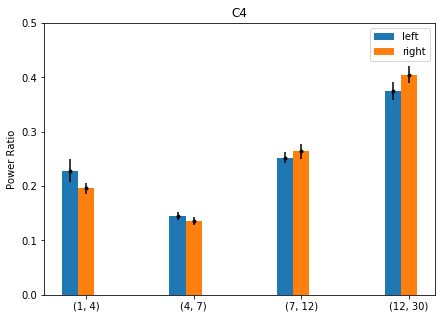

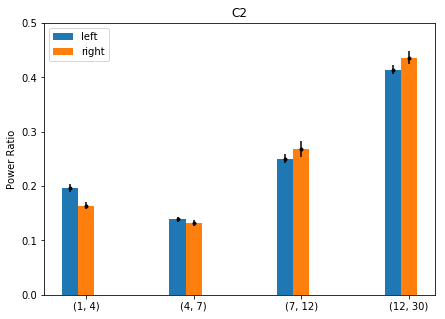

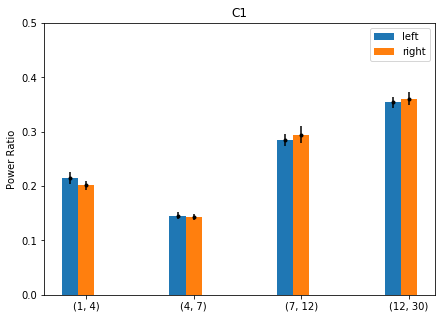

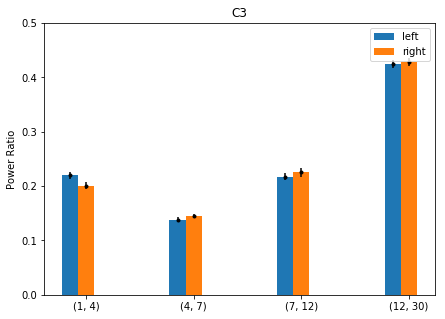

In [23]:
# Plot by channel
# rows = intervals, columns = event types

for chan in eeg_chans: 
    chan_of_interest = chan
    event_power_ratios = {}
    event_sems = {}
    power_ratios_for_chan = []
    sem_for_chan = []
    for event_type in range(1, 3): 
        if event_type not in event_power_ratios: 
            event_power_ratios[event_type] = []
            event_sems[event_type] = []
        for interval in sub_intervals: 
            key = chan_of_interest + "_" + str(interval)
            event_power_ratios[event_type].append(avg_df[key][event_type])
            event_sems[event_type].append(std_err_df[key][event_type])

    event_sems_df = pd.DataFrame(event_sems)
    event_power_ratios_df = pd.DataFrame(event_power_ratios)
    
    plt.figure(figsize=(7,5))
    plt.title(chan_of_interest)
    plt.ylim((0, 0.5))
    plt.ylabel("Power Ratio")
    plotMultipleBarGraphs(np.transpose(np.array(event_power_ratios_df)), 0.15, ['left', 'right'], sub_intervals, error_values=np.transpose(np.array(event_sems_df)))
    
    
